In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import glikonal_grrp as grrp
import matplotlib


In [2]:
@jit(nopython=True)
def glide_ratio(a,wind):
    k=np.linalg.norm(wind) #ratio between the wind speed and the airspeed of the aircraft. gamma should be (1+k)/(1-k)
    return np.sqrt(1-k**2+k**2*np.sum(a*wind)**2)+k*np.sum(a*wind)

## GRRP
The gliding reachable region problem consists of determining the maximal region that is reachable in gliding flight starting from a point.

We implement the algorithm from section 6 of the Sethian paper. This is an ordered upwind method.

We triangulate the square mesh by including as neighbors nodes on the increasing diagonal, i.e. we connect i,j to i+1,j+1.




## Point source test with constant wind and no terrain
In this case the analytic solution is known and we can compare to it.

In [3]:
H=101  #number of horizontal points in the grid
W=101  #number of vertical points in the grid
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=-np.ones([H,W,Z])*3*np.pi/4 #wind angle is measured from the y axis, positive towards east (clockwise). pi/2 is east, 0 is north.
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.6*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength)) #ratio between the largest and lowest value glide_ratio can take. In this case the glide ration in absence of wind is one.
elevation=0*np.ones([H,W]) #elevation profile

#initial position and altitude of aircraft
init_pos=(H//2,W//2) #source position
init_altitude=100

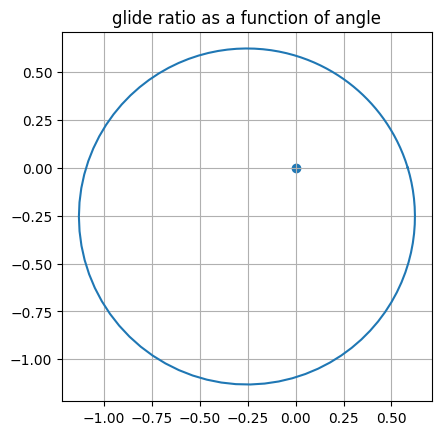

In [4]:
#print the glide ratio as a function of the angle (course angle not heading angle)
circle_vecs=np.array([(np.sin(theta),np.cos(theta)) for theta in np.linspace(0,2*np.pi,100)])
wind=wind_field[0,0,0]
circle_velocities=np.array([glide_ratio(a,wind) for a in circle_vecs])
fig,ax=plt.subplots()
ax.plot(circle_vecs[:,1]*circle_velocities,circle_vecs[:,0]*circle_velocities)
ax.grid()
ax.scatter(0,0)
ax.set_aspect('equal')
ax.set_title('glide ratio as a function of angle')

radius=2.9 
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))

In [5]:
#use the solver to obtain the approximate solution
#grid=grrp.anisotropic_eikonal(velocity_func=velocity,Gamma=Gamma,init_nodes=init_nodes,init_values=init_values, hy=hy,hx=hx, hz=,H=H,W=W)
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars,hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)

In [6]:
#finding the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
true_grid=np.inf*np.ones([H,W])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]



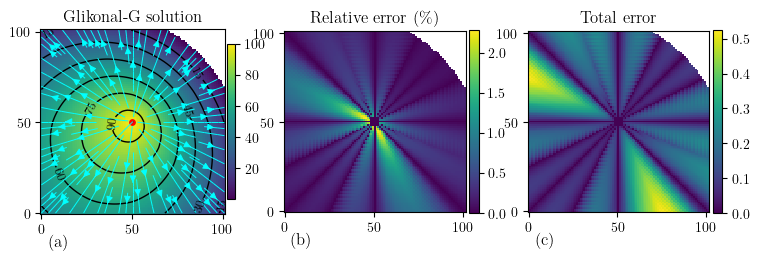

In [7]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
grid_lost_altitude=init_altitude-grid
true_grid_lost_altitude=init_altitude-true_grid
tot_error=grid_lost_altitude-true_grid_lost_altitude
rel_error=tot_error/(true_grid_lost_altitude+1e-10)
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))
fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*hx,init_pos[0]*hy,color='red',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.04, pad=0.01)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.9,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)


plt.savefig('./pics/glikonal_grrp_test_flat.pdf',dpi=600,bbox_inches='tight')

## Test grid with $h_x\neq h_y$
The grid here is rectangular

In [8]:
hy=1.5 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
pos_seed=(H//2,W//2) #source position
radius=2.9 

init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)

Text(0.5, 1.0, 'solution via upwind scheme')

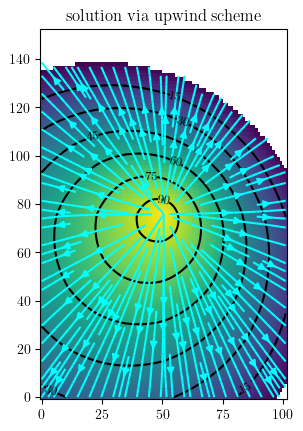

In [9]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

ax.pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,grid,colors='k')
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=1.4,color='aqua')

ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('solution via upwind scheme')

Text(0.5, 1.0, 'true solution')

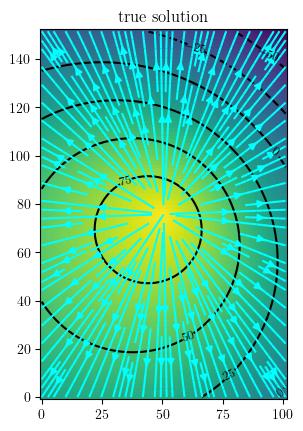

In [10]:
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
true_grid=np.inf*np.ones([H,W])
true_grid_chars=np.zeros([H,W,2])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
    true_grid_chars[pos]=init_chars[i]
    
    
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

ax.pcolormesh(X,Y,true_grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,true_grid,colors='k')
ax.streamplot(X,Y,true_grid_chars[:,:,1],true_grid_chars[:,:,0],density=1.4,color='aqua')

ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('true solution')

Text(0.5, 1.0, 'total error lost altitude')

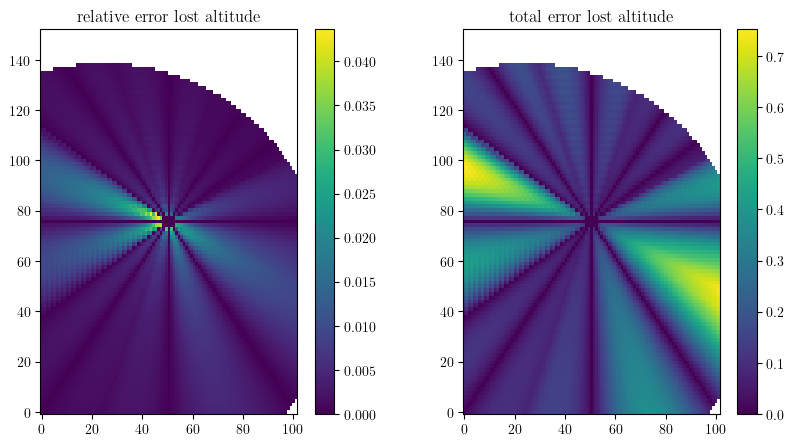

In [11]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
grid_lost_altitude=init_altitude-grid
true_grid_lost_altitude=init_altitude-true_grid
tot_error=grid_lost_altitude-true_grid_lost_altitude
rel_error=tot_error/(true_grid_lost_altitude+1e-10)

fig,axes=plt.subplots(1,2,figsize=(10,5))
im1=axesim1=axes[0].pcolormesh(X,Y,rel_error,cmap='viridis',shading='nearest')
im2=axes[1].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')

fig.colorbar(im1,ax=axes[0])
fig.colorbar(im2,ax=axes[1])
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_title('relative error lost altitude')
axes[1].set_title('total error lost altitude')

## Test with uniform wind and barrier with two slits

In [12]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.4*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind=wind_field[0,0,0]

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#this elevation profile has a barrier that extends from the top to the bottom of the grid, with two slits in at positions saddle_1 and saddle_2.
#each slit is 2 grid points wide
elevation=np.ones([H,W])
elevation[:,W//2]=100*np.ones(H)
saddle_1=80
saddle_2=20
elevation[int(saddle_1/hy)-1:int(saddle_1/hy)+1,:]=1
elevation[int(saddle_2/hy)-1:int(saddle_2/hy)+1,:]=1



#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=120

In [13]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
grid=np.maximum(grid,np.zeros_like(grid))

In [14]:
#computing the true solution
#this can take about 15 mins to run because of the bigger grid
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_pos_saddle1=(int(saddle_1/hy),W//2)
alt_saddle1=init_values[init_nodes.index(init_pos_saddle1)]

init_pos_saddle11=(int(saddle_1/hy)-1,W//2)
alt_saddle11=init_values[init_nodes.index(init_pos_saddle11)]

init_pos_saddle2=(int(saddle_2/hy),W//2)
alt_saddle2=init_values[init_nodes.index(init_pos_saddle2)]

init_pos_saddle22=(int(saddle_2/hy)-1,W//2)
alt_saddle22=init_values[init_nodes.index(init_pos_saddle22)]

init_nodes1,init_values1,init_chars1=grrp.point_source_HJB_uniform_solver(init_pos_saddle1,alt_saddle1,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes11,init_values11,init_chars11=grrp.point_source_HJB_uniform_solver(init_pos_saddle11,alt_saddle11,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))

init_nodes2,init_values2,init_chars2=grrp.point_source_HJB_uniform_solver(init_pos_saddle2,alt_saddle2,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes22,init_values22,init_chars22=grrp.point_source_HJB_uniform_solver(init_pos_saddle22,alt_saddle22,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))


true_grid=np.inf*np.ones([H,W])

for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
for i,pos in enumerate(init_nodes1):
    if(pos[1]>W//2):
        true_grid[pos]=max([init_values2[init_nodes2.index(pos)],init_values1[init_nodes1.index(pos)],init_values22[init_nodes22.index(pos)],init_values11[init_nodes11.index(pos)]])

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
true_grid[true_grid==np.inf]=np.nan

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_61136/2204808.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='w',label='aircraft',linewidths=0.7)


Text(0.5, 1.0, 'glide range (shaded region) plotted on top of the elevation profile')

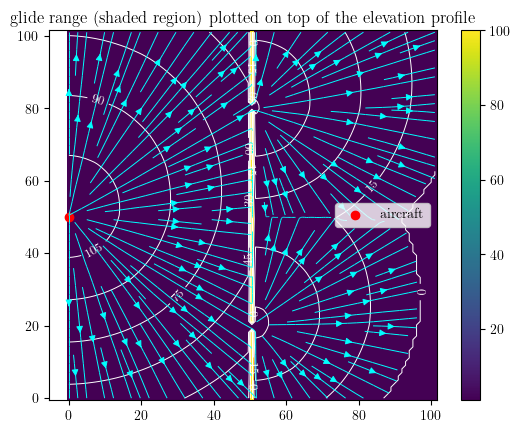

In [15]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft')
ax.legend()
fig.colorbar(pc)
CS=ax.contour(X,Y,grid,colors='w',label='aircraft',linewidths=0.7)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=1.4,color='aqua',linewidth=0.7)

ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')

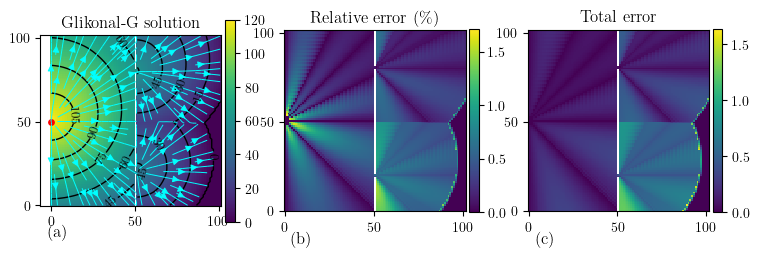

In [16]:
mid_line=grid[:,W//2].copy()
true_mid_line=true_grid[:,W//2].copy()
grid[:,W//2]=np.nan
true_grid[:,W//2]=np.nan
grid[int(saddle_1/hy)-1:int(saddle_1/hy)+1,W//2]=mid_line[int(saddle_1/hy)-1:int(saddle_1/hy)+1]
true_grid[int(saddle_1/hy)-1:int(saddle_1/hy)+1,W//2]=true_mid_line[int(saddle_1/hy)-1:int(saddle_1/hy)+1]
grid[int(saddle_2/hy)-1:int(saddle_2/hy)+1,W//2]=mid_line[int(saddle_2/hy)-1:int(saddle_2/hy)+1]
true_grid[int(saddle_2/hy)-1:int(saddle_2/hy)+1,W//2]=true_mid_line[int(saddle_2/hy)-1:int(saddle_2/hy)+1]
#print(true_grid[:,W//2])
lost_altitude=init_altitude-grid
true_lost_altitude=init_altitude-true_grid
tot_error=lost_altitude-true_lost_altitude
rel_error=tot_error/(true_lost_altitude+1e-10)
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))

fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*hx,init_pos[0]*hy,color='red',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.052, pad=0.02)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.9,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)
plt.savefig('./pics/glikonal_grrp_test_2saddles.pdf',dpi=600,bbox_inches='tight')



### Example with same elevation profile but smaller grid spacing.
We want to show that reducing the grid spacing, the solutino found by glikonal-g approaches the true solution.
here we set hx=hy=0.25 and H,W=404


In [17]:
H=404 
W=404
Z=20 #number of vertical points in the wind vector field

hy=0.25 #grid spacing in the y direction
hx=0.25 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.4*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind=wind_field[0,0,0]

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#this elevation profile has a barrier that extends from the top to the bottom of the grid, with two slits in at positions saddle_1 and saddle_2.
#each slit is 2 grid points wide
elevation=np.ones([H,W])
elevation[:,W//2]=100*np.ones(H)
saddle_1=80
saddle_2=20
elevation[int(saddle_1/hy)-1:int(saddle_1/hy)+1,:]=1
elevation[int(saddle_2/hy)-1:int(saddle_2/hy)+1,:]=1



#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=120

In [18]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
grid=np.maximum(grid,np.zeros_like(grid))

In [19]:
#computing the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_pos_saddle1=(int(saddle_1/hy),W//2)
alt_saddle1=init_values[init_nodes.index(init_pos_saddle1)]

init_pos_saddle11=(int(saddle_1/hy)-1,W//2)
alt_saddle11=init_values[init_nodes.index(init_pos_saddle11)]

init_pos_saddle2=(int(saddle_2/hy),W//2)
alt_saddle2=init_values[init_nodes.index(init_pos_saddle2)]

init_pos_saddle22=(int(saddle_2/hy)-1,W//2)
alt_saddle22=init_values[init_nodes.index(init_pos_saddle22)]

init_nodes1,init_values1,init_chars1=grrp.point_source_HJB_uniform_solver(init_pos_saddle1,alt_saddle1,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes11,init_values11,init_chars11=grrp.point_source_HJB_uniform_solver(init_pos_saddle11,alt_saddle11,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))

init_nodes2,init_values2,init_chars2=grrp.point_source_HJB_uniform_solver(init_pos_saddle2,alt_saddle2,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes22,init_values22,init_chars22=grrp.point_source_HJB_uniform_solver(init_pos_saddle22,alt_saddle22,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))


true_grid=np.inf*np.ones([H,W])

for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
for i,pos in enumerate(init_nodes1):
    if(pos[1]>W//2):
        true_grid[pos]=max([init_values2[init_nodes2.index(pos)],init_values1[init_nodes1.index(pos)],init_values22[init_nodes22.index(pos)],init_values11[init_nodes11.index(pos)]])

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
true_grid[true_grid==np.inf]=np.nan

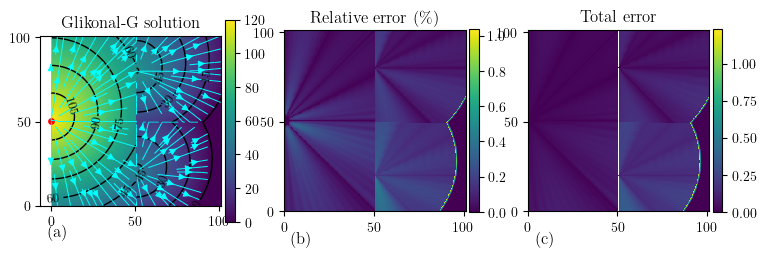

In [20]:
mid_line=grid[:,W//2].copy()
true_mid_line=true_grid[:,W//2].copy()
grid[:,W//2]=np.nan
true_grid[:,W//2]=np.nan
grid[int(saddle_1/hy)-1:int(saddle_1/hy)+1,W//2]=mid_line[int(saddle_1/hy)-1:int(saddle_1/hy)+1]
true_grid[int(saddle_1/hy)-1:int(saddle_1/hy)+1,W//2]=true_mid_line[int(saddle_1/hy)-1:int(saddle_1/hy)+1]
grid[int(saddle_2/hy)-1:int(saddle_2/hy)+1,W//2]=mid_line[int(saddle_2/hy)-1:int(saddle_2/hy)+1]
true_grid[int(saddle_2/hy)-1:int(saddle_2/hy)+1,W//2]=true_mid_line[int(saddle_2/hy)-1:int(saddle_2/hy)+1]
#print(true_grid[:,W//2])
lost_altitude=init_altitude-grid
true_lost_altitude=init_altitude-true_grid
tot_error=lost_altitude-true_lost_altitude
rel_error=tot_error/(true_lost_altitude+1e-10)
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))

fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*hx,init_pos[0]*hy,color='red',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.052, pad=0.02)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.9,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)
plt.savefig('./pics/glikonal_grrp_test_2saddles_h025.png',dpi=600,bbox_inches='tight')


## Example of mountain range without passes
In this case, the glider can pass the mountain range if it flies directly towards it, but arrives too low if it proceed obliquously.


In [21]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.3*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind=wind_field[0,0,0]

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#this elevation profile has a barrier that extends from the top to the bottom of the grid, with two slits in at positions saddle_1 and saddle_2.
#each slit is 2 grid points wide
elevation=np.ones([H,W])
elevation[:,W//2]=45*np.ones(H)




#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=100

In [22]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
grid=np.maximum(grid,np.zeros_like(grid))


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_61136/1068036759.py:42: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,true_grid,colors='w',label='aircraft',linewidths=0.7)


Text(0.5, 1.0, 'glide range (shaded region) plotted on top of the elevation profile')

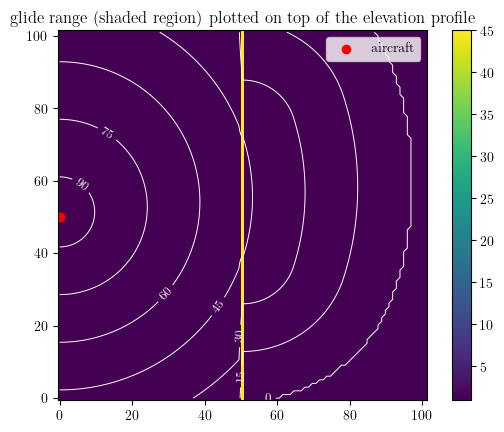

In [23]:
true_grid=np.zeros([H,W])
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
for y in range(H):
    for x in range(W):
        true_grid[y,x]=init_values[init_nodes.index((y,x))]

blocked_down_y=0
for y in range(0,H//2):
    if(elevation[y,W//2]>true_grid[y,W//2]):
        blocked_down_y=y
blocked_down_y=blocked_down_y+1

for y in range(H//2,H):
    if(elevation[y,W//2]>true_grid[y,W//2]):
        blocked_up_y=y
        break
blocked_up_y=blocked_up_y-1
init_nodes_up,init_values_up,init_chars_up=grrp.point_source_HJB_uniform_solver((blocked_up_y,W//2),true_grid[blocked_up_y,W//2],2*radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes_down,init_values_down,init_chars_down=grrp.point_source_HJB_uniform_solver((blocked_down_y,W//2),true_grid[blocked_down_y,W//2],2*radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
for x in range(W//2,W):
    for y in range(0,blocked_down_y):
        y_int=y+(x-W//2)/x*(init_pos[0]-y)
        if(y_int<blocked_down_y):
            true_grid[y,x]=init_values_down[init_nodes_down.index((y,x))]
for x in range(W//2,W):
    for y in range(blocked_up_y,H):
        y_int=y+(x-W//2)/x*(init_pos[0]-y)
        if(y_int>blocked_up_y):
            true_grid[y,x]=init_values_up[init_nodes_up.index((y,x))]

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
     
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft')
ax.legend()
fig.colorbar(pc)
CS=ax.contour(X,Y,true_grid,colors='w',label='aircraft',linewidths=0.7)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')


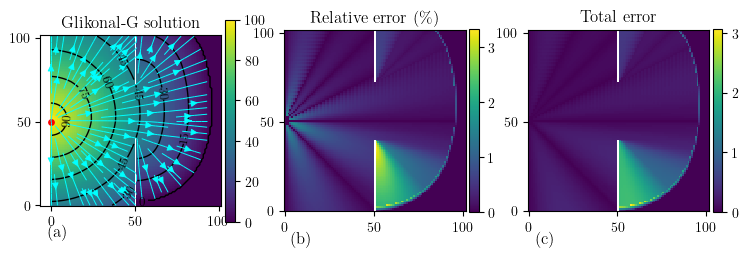

In [24]:
mid_line=grid[:,W//2].copy()
true_mid_line=true_grid[:,W//2].copy()
grid[:,W//2]=np.nan
true_grid[:,W//2]=np.nan
grid[int(blocked_down_y/hy)+1:int(blocked_up_y/hy)+1,W//2]=mid_line[int(blocked_down_y/hy)+1:int(blocked_up_y/hy)+1]
true_grid[int(blocked_down_y/hy)+1:int(blocked_up_y/hy)+1,W//2]=true_mid_line[int(blocked_down_y/hy)+1:int(blocked_up_y/hy)+1]

lost_altitude=init_altitude-grid
true_lost_altitude=init_altitude-true_grid
tot_error=lost_altitude-true_lost_altitude
rel_error=tot_error/(true_lost_altitude+1e-10)
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))

fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*hx,init_pos[0]*hy,color='red',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.052, pad=0.02)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.9,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)
plt.savefig('./pics/glikonal_grrp_test_mount_range.pdf',dpi=600,bbox_inches='tight')

## Remarks
Tests should be considered passed when the relative error is less than 5%.
Notice that when an error is present the altitude of the glider is always underestimated, leading to more conservative predictions.
In particular the lost altitude computed by the algorithm is larger than the true lost altitude.